# S06-demo-03 – Boosting и Stacking

Этот ноутбук можно проходить **самостоятельно**: запускайте ячейки сверху вниз и внимательно сравнивайте качество на train/test и форму границы решений.

## Что вы изучите

- чем **boosting** отличается от **bagging** (и почему boosting часто даёт сильное качество);
- как работают два “классических” варианта boosting:
  - **AdaBoost** (последовательное исправление ошибок через “веса” объектов),
  - **Gradient Boosting** (последовательное уменьшение функции потерь маленькими шагами);
- что такое **stacking** и почему для него критически важно делать обучение **честно** (через out-of-fold предсказания).

## План эксперимента

1) **Интуиция на 2D** (`make_moons`): посмотрим, как ансамбли строят нелинейную границу решений.
2) **Сравнение по метрикам** на табличных данных (`breast_cancer`): accuracy, F1, ROC-AUC.  
3) **Демонстрация утечки**: почему “наивный” stacking может показывать завышенные метрики и как сделать правильно.

## Как читать результаты

- Если **train заметно лучше test**, это признак переобучения (высокая дисперсия).
- В 2D-графиках смотрите не только на качество, но и на **геометрию границы**:
  - слишком "рваная" граница часто означает переобучение,
  - слишком простая – недообучение (высокий bias).


## 0. Импорты и вспомогательные функции

В начале подключаем библиотеки и определяем небольшие функции, которые будут:
- печатать метрики (accuracy / F1 / ROC-AUC и confusion matrix);
- рисовать границу решений в 2D (для `make_moons`);
- обучать модель и сразу оценивать её на отложенной выборке.

Если что-то из этого выглядит незнакомым – просто продолжайте, а затем вернитесь и перечитайте после первого запуска.


In [1]:
# Базовые численные вычисления и визуализация
import numpy as np
import matplotlib.pyplot as plt

# Датасеты:
# - make_moons – 2D, удобно рисовать границы решений
# - breast_cancer – табличные данные для сравнения метрик
from sklearn.datasets import make_moons, load_breast_cancer

# Разбиение и "честные" OOF-предсказания (важно для корректного stacking)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict

# Метрики бинарной классификации
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Базовые модели и инструменты пайплайна
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Ансамбли: boosting, (контекст) bagging, и stacking
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)

# Фиксируем "сид" для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# Вспомогательные функции, чтобы код ниже был короче и читабельнее.

def print_metrics(y_true, y_pred, y_proba=None, title=None):
    # Печатаем несколько полезных метрик для бинарной классификации.
    # ROC-AUC считаем только если есть вероятности/скор (y_proba).
    if title:
        print(title)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"accuracy = {acc:.4f}")
    print(f"f1       = {f1:.4f}")
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"roc_auc  = {auc:.4f}")
        except Exception:
            # На случай, если y_proba по каким-то причинам некорректный (редко, но бывает)
            pass
    print("confusion_matrix:")
    print(confusion_matrix(y_true, y_pred))
    print()

def plot_decision_boundary_2d(model, X, y, title=None, steps=350):
    # Визуализация границы решения для 2D-данных:
    # 1) строим сетку точек (grid) на плоскости признаков,
    # 2) предсказываем класс для каждой точки,
    # 3) рисуем фон (contourf) и поверх – реальные точки.
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps),
                         np.linspace(y_min, y_max, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, zz, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
    if title:
        plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

def eval_binary(model, X_train, y_train, X_test, y_test, title=None):
    # Мини-обёртка: обучить модель на train и оценить на test.
    # Возвращаем обученную модель – её удобно дальше использовать (например, рисовать границу).
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        # Для ROC-AUC нужна "уверенность" модели: вероятность положительного класса
        proba = model.predict_proba(X_test)[:, 1]
    print_metrics(y_test, pred, y_proba=proba, title=title)
    return model


## 1. Интуиция на 2D-датасете (make_moons)

`make_moons` – синтетический датасет из двух "полумесяцев".  
Он удобен тем, что:
- признаков всего два → можно рисовать точки и границу решения;
- хорошая модель должна строить **нелинейную** границу.

В этой части мы будем смотреть на две вещи одновременно:
1) **метрики** на test (не на train);  
2) **картинку границы решений**, чтобы "почувствовать" переобучение глазами.

**Самопроверка:** как вы думаете, сможет ли линейная модель хорошо отделить два полумесяца? Что будет, если сделать базовые деревья слишком глубокими?


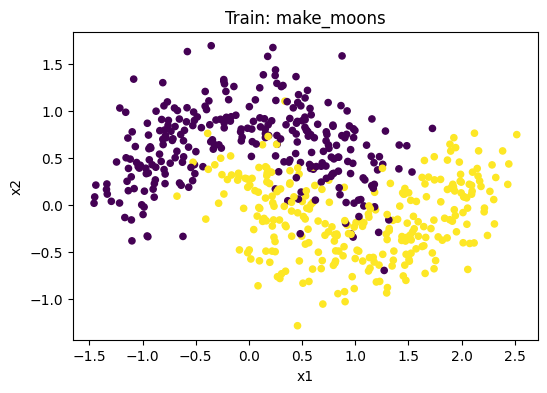

In [ ]:
# Генерируем 2D-датасет "полумесяцы" с шумом:
# шум специально добавлен, чтобы задача была не "игрушечной" и граница решений не была идеальной.
X, y = make_moons(n_samples=800, noise=0.28, random_state=RANDOM_STATE)

# Честное разбиение на train/test (стратификация сохраняет доли классов)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

# Сначала просто посмотрим на точки train
plt.figure(figsize=(6, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20)
plt.title("Train: make_moons")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


## 2. Boosting: AdaBoost

**Boosting** строит ансамбль **последовательно**: каждая следующая модель пытается исправить ошибки предыдущих.

### AdaBoost – интуиция
Классический AdaBoost часто используют с **решающими пнями** (деревья глубины 1).
Идея (очень упрощённо):
- после очередной итерации "сложные" объекты получают больший вес;
- следующая модель больше "внимания" уделяет именно этим объектам;
- итог – взвешенная комбинация многих слабых моделей.

Важно помнить две ручки:
- `n_estimators` – сколько итераций (сколько слабых моделей в ансамбле);
- `learning_rate` – насколько "сильным" будет вклад каждой итерации.

**Самопроверка:** почему увеличение `n_estimators` может **ухудшать** качество на test? Как связаны `learning_rate` и количество итераций?


AdaBoost (stumps) – test
accuracy = 0.9250
f1       = 0.9237
roc_auc  = 0.9809
confusion_matrix:
[[113   7]
 [ 11 109]]



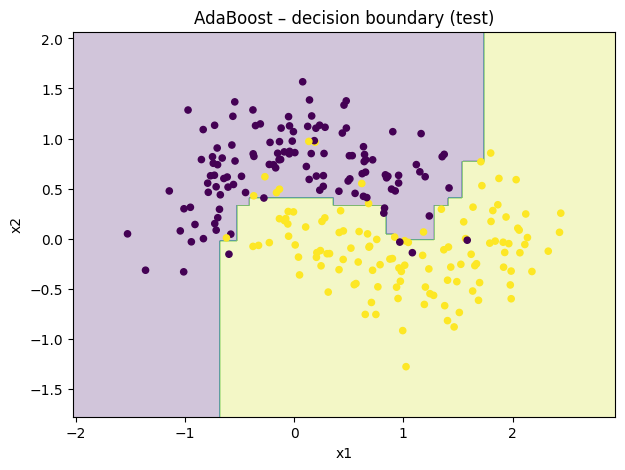

In [4]:
# AdaBoost обычно демонстрируют с "пнями" – деревьями глубины 1:
# это слабая модель, но boosting умеет собирать из слабых моделей сильную.
stump = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE)

# Параметры AdaBoost:
# - n_estimators: сколько итераций (сколько слабых моделей будет в ансамбле)
# - learning_rate: вклад каждой итерации (шаг)
ada = AdaBoostClassifier(
    estimator=stump,
    n_estimators=200,
    learning_rate=0.6,
    random_state=RANDOM_STATE
)

# Обучаем и оцениваем на test (важно: именно на test!)
ada = eval_binary(ada, X_train, y_train, X_test, y_test, title="AdaBoost (stumps) – test")

# Смотрим на границу решения: где модель разделяет классы на плоскости признаков
plot_decision_boundary_2d(ada, X_test, y_test, title="AdaBoost – decision boundary (test)")


### 2.1. Как влияет `n_estimators` и `learning_rate`

В boosting есть типичный компромисс:

- **больше итераций** (`n_estimators`) часто улучшает качество до некоторой точки,  
  но затем может начаться переобучение;
- **меньше шаг** (`learning_rate`) делает обучение "осторожнее",  
  но обычно требует **больше итераций**.

Ниже мы посмотрим зависимость качества от числа итераций и сравним train vs test.

**На что смотреть:**
- если train растёт, а test перестал расти или падает – это сигнал переобучения;
- интересует не "максимальный train", а "лучший test".


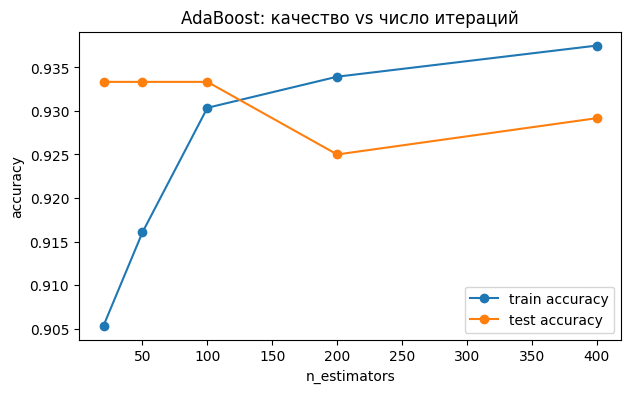

In [5]:
# Посмотрим, как качество зависит от числа итераций.
# Важно: нас интересует не только "чем больше, тем лучше", а разница train vs test.
n_estimators_grid = [20, 50, 100, 200, 400]
train_acc = []
test_acc = []

for n_est in n_estimators_grid:
    m = AdaBoostClassifier(estimator=stump, n_estimators=n_est, learning_rate=0.6, random_state=RANDOM_STATE)
    m.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, m.predict(X_train)))
    test_acc.append(accuracy_score(y_test, m.predict(X_test)))

# График "учебной кривой" (очень упрощённой): train и test accuracy
plt.figure(figsize=(7, 4))
plt.plot(n_estimators_grid, train_acc, marker="o", label="train accuracy")
plt.plot(n_estimators_grid, test_acc, marker="o", label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.title("AdaBoost: качество vs число итераций")
plt.legend()
plt.show()


## 3. Boosting: Gradient Boosting

**Gradient Boosting** тоже строит ансамбль последовательно, но интерпретация другая:
мы добавляем модель так, чтобы **уменьшать функцию потерь** (градиентный шаг).

В `sklearn` это `GradientBoostingClassifier`, где базовые модели – небольшие деревья.

Управляющие параметры похожи по смыслу на AdaBoost:
- `n_estimators` – сколько шагов;
- `learning_rate` – размер шага;
- `max_depth` – “сила” базового дерева (глубже → гибче → выше риск переобучения).


GradientBoosting – test
accuracy = 0.9250
f1       = 0.9217
roc_auc  = 0.9797
confusion_matrix:
[[116   4]
 [ 14 106]]



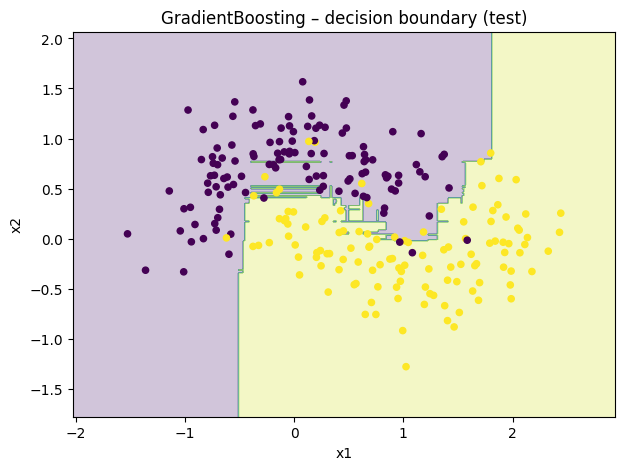

In [6]:
# Gradient Boosting: чаще всего сильнее, чем одиночные деревья и многие простые модели.
# Здесь используем небольшую глубину базовых деревьев (max_depth=2) и маленький шаг (learning_rate=0.05).
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=2,
    random_state=RANDOM_STATE
)

gb = eval_binary(gb, X_train, y_train, X_test, y_test, title="GradientBoosting – test")
plot_decision_boundary_2d(gb, X_test, y_test, title="GradientBoosting – decision boundary (test)")


### 3.1. Sanity-check: переобучение и глубина деревьев

Для GBDT полезно иметь "быструю проверку здравого смысла":
если делать базовые деревья слишком глубокими, ансамбль становится слишком гибким.

Баланс обычно такой:
- глубже деревья → проще "подогнать" train → риск переобучения выше;
- мельче деревья → модель стабильнее, но может не хватать выразительности.

Ниже мы изменим `max_depth` и посмотрим, как меняется качество на test.

**Самопроверка:** какой depth выглядит разумным для `make_moons` и почему?


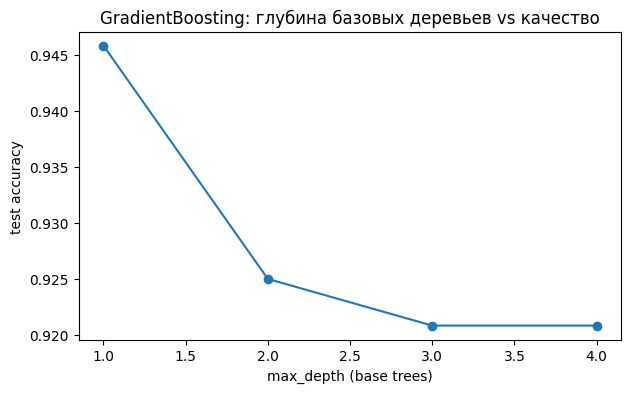

In [7]:
# Быстро проверим влияние глубины базовых деревьев на качество.
# На практике depth влияет на "гибкость" модели и риск переобучения.
depths = [1, 2, 3, 4]
test_scores = []

for d in depths:
    m = GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=d,
        random_state=RANDOM_STATE
    )
    m.fit(X_train, y_train)
    test_scores.append(accuracy_score(y_test, m.predict(X_test)))

plt.figure(figsize=(7, 4))
plt.plot(depths, test_scores, marker="o")
plt.xlabel("max_depth (base trees)")
plt.ylabel("test accuracy")
plt.title("GradientBoosting: глубина базовых деревьев vs качество")
plt.show()


## 4. Stacking: комбинируем разные модели (правильно!)

**Stacking** – это ансамбль “другого типа”:
1) несколько **базовых** моделей дают предсказания;  
2) мы обучаем **метамодель**, которая учится их комбинировать.

Почему это может работать:
- разные модели ошибаются по-разному;
- метамодель учится “кому доверять” в разных областях пространства признаков.

### Критическое правило честности
Метамодель должна учиться на **out-of-fold (OOF)** предсказаниях базовых моделей:
- для каждой точки train предсказание должно быть сделано моделью, которая **не видела** эту точку при обучении;
- иначе получится утечка, и метамодель “подсмотрит” ответы.

В `sklearn` это правило уже встроено в `StackingClassifier` (через параметр `cv`).


StackingClassifier – test
accuracy = 0.9208
f1       = 0.9177
roc_auc  = 0.9776
confusion_matrix:
[[115   5]
 [ 14 106]]



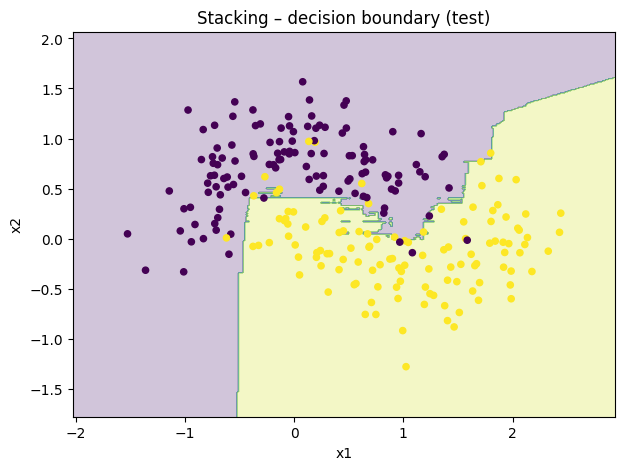

In [8]:
# Stacking: соберём несколько разных базовых моделей.
# Идея: базовые модели должны быть действительно 'разными', чтобы метамодели было чему научиться.
# Здесь: логистическая регрессия (гладкая граница) + RandomForest + GradientBoosting.
estimators = [
    ("lr", Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=2000))])),
    ("rf", RandomForestClassifier(n_estimators=250, random_state=RANDOM_STATE, n_jobs=-1)),
    ("gb", GradientBoostingClassifier(n_estimators=250, learning_rate=0.05, max_depth=2, random_state=RANDOM_STATE)),
]

final_est = LogisticRegression(max_iter=2000)

# Важно: StackingClassifier сам делает 'честный' стекинг через CV (параметр cv).
# То есть метамодель учится на out-of-fold предсказаниях базовых моделей, без утечки.
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=final_est,
    cv=5,
    n_jobs=-1,
    passthrough=False  # если True, метамодель видит и исходные признаки тоже
)

stack = eval_binary(stack, X_train, y_train, X_test, y_test, title="StackingClassifier – test")
plot_decision_boundary_2d(stack, X_test, y_test, title="Stacking – decision boundary (test)")

## 5. Табличный датасет: breast_cancer (метрики + ROC-AUC)

Теперь перейдём к “реалистичному” табличному датасету:
много признаков → границу решений не нарисуем, зато сравним модели как в инженерной практике.

Мы будем смотреть:
- **accuracy** (доля верных ответов),
- **F1** (баланс precision/recall, полезно при перекосе классов),
- **ROC-AUC** (качество ранжирования вероятностей, менее зависит от выбранного порога 0.5),
- **confusion matrix** (какие ошибки делаем: FP/FN).

Важно:
ROC-AUC корректно смотреть только если у модели есть `predict_proba` (или аналогичная оценка “уверенности”).


In [9]:
# Табличный датасет: здесь много признаков, поэтому сравниваем модели по метрикам.
# Важно: оцениваем качество на отложенной выборке (test), а не только на train.

# Загружаем данные (классика для бинарной классификации).
data = load_breast_cancer()
X = data["data"]
y = data["target"]
feature_names = list(data["feature_names"])


# Разбиваем на train/test со стратификацией.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# Baseline: простая модель, с которой удобно сравнивать более сложные.
# baseline: логистическая регрессия (с масштабированием)
lr = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=3000))])
lr = eval_binary(lr, X_train, y_train, X_test, y_test, title="Tabular – LogisticRegression (baseline)")

# RandomForest: bagging-ансамбль. Часто даёт неплохой старт, но бустинг нередко сильнее.
# RandomForest (контекст)
rf = RandomForestClassifier(n_estimators=600, random_state=RANDOM_STATE, n_jobs=-1, oob_score=True)
rf = eval_binary(rf, X_train, y_train, X_test, y_test, title="Tabular – RandomForest")
# OOB-score (out-of-bag) – внутренняя оценка для RF; здесь выводим для иллюстрации.
print(f"RandomForest oob_score_ = {rf.oob_score_:.4f}\n")

# GradientBoosting: последовательное уменьшение функции потерь (классический GBDT).
# Boosting: GradientBoosting
gb = GradientBoostingClassifier(n_estimators=600, learning_rate=0.03, max_depth=2, random_state=RANDOM_STATE)
gb = eval_binary(gb, X_train, y_train, X_test, y_test, title="Tabular – GradientBoosting")

# HistGradientBoosting: более быстрый вариант (особенно на больших данных).
# Boosting (быстрый): HistGradientBoosting
hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=3, learning_rate=0.05)
hgb = eval_binary(hgb, X_train, y_train, X_test, y_test, title="Tabular – HistGradientBoosting")

# Stacking: комбинируем разные модели. Важно: внутри будет CV (cv=5) → честное обучение метамодели.
# Stacking: смешаем baseline + RF + boosting
estimators_tab = [
    ("lr", Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=3000))])),
    ("rf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)),
    ("gb", GradientBoostingClassifier(n_estimators=400, learning_rate=0.05, max_depth=2, random_state=RANDOM_STATE)),
]
stack_tab = StackingClassifier(estimators=estimators_tab, final_estimator=LogisticRegression(max_iter=3000), cv=5, n_jobs=-1)
stack_tab = eval_binary(stack_tab, X_train, y_train, X_test, y_test, title="Tabular – StackingClassifier")

Tabular – LogisticRegression (baseline)
accuracy = 0.9860
f1       = 0.9889
roc_auc  = 0.9977
confusion_matrix:
[[52  1]
 [ 1 89]]

Tabular – RandomForest
accuracy = 0.9580
f1       = 0.9670
roc_auc  = 0.9943
confusion_matrix:
[[49  4]
 [ 2 88]]

RandomForest oob_score_ = 0.9624

Tabular – GradientBoosting
accuracy = 0.9580
f1       = 0.9670
roc_auc  = 0.9935
confusion_matrix:
[[49  4]
 [ 2 88]]

Tabular – HistGradientBoosting
accuracy = 0.9580
f1       = 0.9674
roc_auc  = 0.9948
confusion_matrix:
[[48  5]
 [ 1 89]]

Tabular – StackingClassifier
accuracy = 0.9720
f1       = 0.9780
roc_auc  = 0.9973
confusion_matrix:
[[50  3]
 [ 1 89]]



## 6. Почему “наивный” stacking опасен (пример утечки)

Здесь специально покажем **неправильный** способ построить stacking, чтобы вы увидели проблему руками.

### Неправильная схема (утечка)
1) обучили базовые модели на train;  
2) взяли их предсказания **на том же train** и обучили метамодель;  
3) получили “слишком хорошую” метрику (метамодель фактически видит результаты моделей, которые уже были обучены на этих же точках).

Это завышает качество и может создать ложное ощущение “вот оно, решение”.

### Правильная схема
Для обучения метамодели используем **OOF-предсказания** через CV:
- каждая точка train предсказана моделью, которая её **не видела**;
- для test: обучаем базовую модель на полном train и предсказываем test (так обычно и делают).

В коде ниже это реализовано через `cross_val_predict(..., method="predict_proba")` и `StratifiedKFold`.


In [ ]:
# Демонстрация утечки в "наивном" стекинге на табличных данных.
# Здесь цель не "выжать максимум качества", а увидеть разницу между неправильной и правильной схемой.

- Базовые модели для демонстрации (табличные данные)
base_models = [
    Pipeline([(«scaler», StandardScaler()), («lr», LogisticRegression(max_iter=3000))]),
    RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=2, random_state=RANDOM_STATE),
]

# 6.1 Неправильно: мета-датасет делаем предсказаниями на том же train
# Проблема: базовые модели уже "видели" эти точки → их предсказания на train слишком оптимистичны.
# Метамодель учится на переоценённых признаках и затем показывает завышенную метрику.
Z_train_bad = []
Z_test_bad = []
for m in base_models:
    m.fit(X_train, y_train)
    Z_train_bad.append(m.predict_proba(X_train)[:, 1])
    Z_test_bad.append(m.predict_proba(X_test)[:, 1])

Z_train_bad = np.vstack(Z_train_bad).T
Z_test_bad = np.vstack(Z_test_bad).T

meta = LogisticRegression(max_iter=3000)
meta.fit(Z_train_bad, y_train)
proba_bad = meta.predict_proba(Z_test_bad)[:, 1]
pred_bad = (proba_bad >= 0.5).astype(int)

print_metrics(y_test, pred_bad, y_proba=proba_bad, title="Naive stacking (LEAK) – test")

# 6.2 Правильно: для Z_train используем out-of-fold предсказания
# Для каждой точки train предсказание делается моделью, которая НЕ обучалась на этой точке.
# Это можно получить через cross_val_predict с method="predict_proba".
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Z_train_good = []
Z_test_good = []

for m in base_models:
    # OOF предсказания на train (каждая точка предсказана моделью, которая не видела её при обучении)
    oof_proba = cross_val_predict(m, X_train, y_train, cv=cv, method="predict_proba")[:, 1]
    Z_train_good.append(oof_proba)

    # Для test: обучаем модель на полном train и предсказываем test (так обычно и делают)
    m.fit(X_train, y_train)
    Z_test_good.append(m.predict_proba(X_test)[:, 1])

Z_train_good = np.vstack(Z_train_good).T
Z_test_good = np.vstack(Z_test_good).T

meta2 = LogisticRegression(max_iter=3000)
meta2.fit(Z_train_good, y_train)
proba_good = meta2.predict_proba(Z_test_good)[:, 1]
pred_good = (proba_good >= 0.5).astype(int)

print_metrics(y_test, pred_good, y_proba=proba_good, title="Proper stacking (OOF) – test")


Naive stacking (LEAK) – test
accuracy = 0.9650
f1       = 0.9727
roc_auc  = 0.9964
confusion_matrix:
[[49  4]
 [ 1 89]]

Proper stacking (OOF) – test
accuracy = 0.9720
f1       = 0.9780
roc_auc  = 0.9973
confusion_matrix:
[[50  3]
 [ 1 89]]



## 7. Выводы и что запомнить

- **Boosting** (AdaBoost/GBDT/HGB) – последовательное построение ансамбля. Часто даёт сильное качество “из коробки”,  
  но чувствителен к настройкам (`learning_rate`, глубина базовых деревьев, число итераций) и легко переобучается при агрессивных параметрах.

- **Stacking** – способ “смешать” разные модели через метамодель. Может дать прирост, когда базовые модели действительно разные,  
  но его нельзя делать “в лоб”: метамодель должна учиться на **OOF** предсказаниях (через CV), иначе будет утечка.

- Практическая эвристика:
  - если нужно быстро и сильно на табличных данных – часто начинают с boosting (GBDT / HistGB / аналоги);
  - stacking используют, когда уже есть несколько сильных моделей и хочется аккуратно “выжать” ещё немного качества,
    при этом строго соблюдая честную схему валидации.
